In [123]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
import pickle
import pandas
from sklearn.metrics import mean_squared_error

# Andiamo a costruire il modello LSTM

In [124]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


(150, 1)


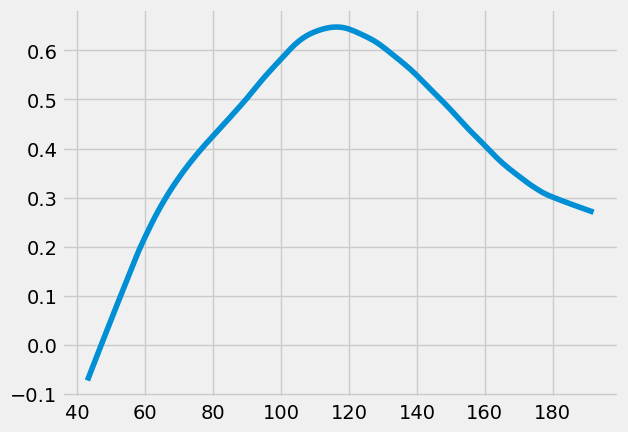

In [125]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print()
NDVI[30].plot()

dataset = np.reshape(NDVI[30].data_matrix.flatten(),(NDVI[30].data_matrix.flatten().shape[0],1))
#pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

print(dataset.shape)

In [126]:
# Checking for missing values dataset[:'2016'].iloc[:,1:2].values
trainingLenght = 120
testLenght = 30

training_set = dataset[:trainingLenght]
print(training_set.shape)
print(len(training_set))
test_set = dataset[trainingLenght:]
print(test_set.shape)
print(len(test_set))

(120, 1)
120
(30, 1)
30


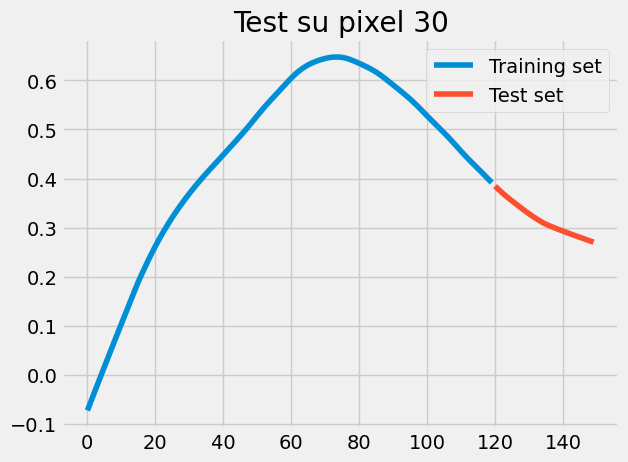

In [127]:
s = pd.Series(dataset.flatten())
s[:trainingLenght].plot(legend=True)
s[trainingLenght:].plot(legend=True)
plt.legend(['Training set','Test set'])
plt.title('Test su pixel 30')
plt.show()

In [128]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [129]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
Window = 10
X_train = []
y_train = []
for i in range(Window,trainingLenght):
    X_train.append(training_set_scaled[i-Window:i,0])
    y_train.append(training_set_scaled[i,0])
    '''print(training_set_scaled[i-60:i,0])
    print(training_set_scaled[i,0])'''
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train[2])

[0.0497174  0.07444644 0.09908683 0.12363859 0.14810157 0.17247447
 0.19675603 0.22095236 0.24507219 0.26912569]


In [130]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
print(y_train.shape)

(110, 10, 1)
(110,)


In [131]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [132]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
4/4 [==============================] - 7s 16ms/step - loss: 0.5212
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0566
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0144
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0225
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0131
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0248
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0098
Epoch 8/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0090
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0164
Epoch 10/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0166
Epoch 11/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0188
Epoch 12/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0164
Epoch 13/50
4/4 [==============================] - 0s 15ms/st

In [133]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((s[:trainingLenght],s[trainingLenght:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)-Window:].values # Da qui ho tolto - 10
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [134]:
# Preparing X_test and predicting the prices

X_test = []
for i in range(Window,testLenght+Window):
    X_test.append(inputs[i-Window:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 1s/step


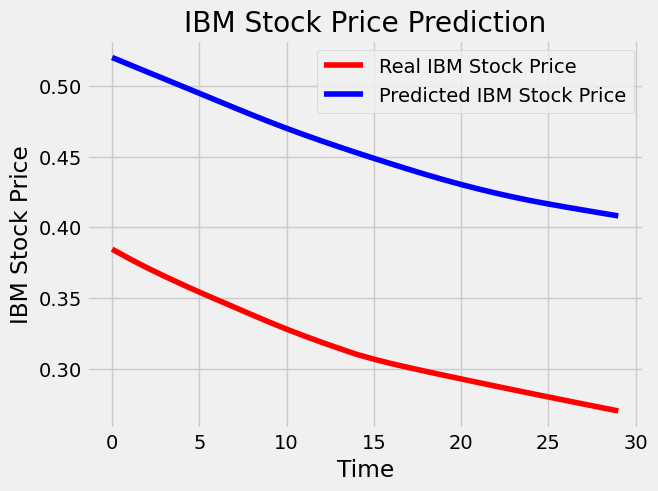

In [135]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [136]:
# Evaluating our model
print(test_set.shape)
print(predicted_stock_price.shape)
return_rmse(test_set,predicted_stock_price)

(30, 1)
(30, 1)
The root mean squared error is 0.1392884551095027.


# Andiamo a costruire il modello GRU

In [137]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


c:\Users\Leo\.conda\envs\Agrivision\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 7s 7s/step - loss: 0.6102
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 0.4625
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2579
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0930
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0369
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0993
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1906
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2474
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 0.2261
Epoch 10/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1619
Epoch 11/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0846
Epoch 12/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0399
Epoch 13/50
1/1 [==============================] - 0s 22ms/step - loss: 0.

In [138]:
# Preparing X_test and predicting the prices
print(X_test.shape)
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

(30, 10, 1)


C:\Users\Leo\AppData\Local\Temp\ipykernel_4372\2450153322.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test)


IndexError: tuple index out of range

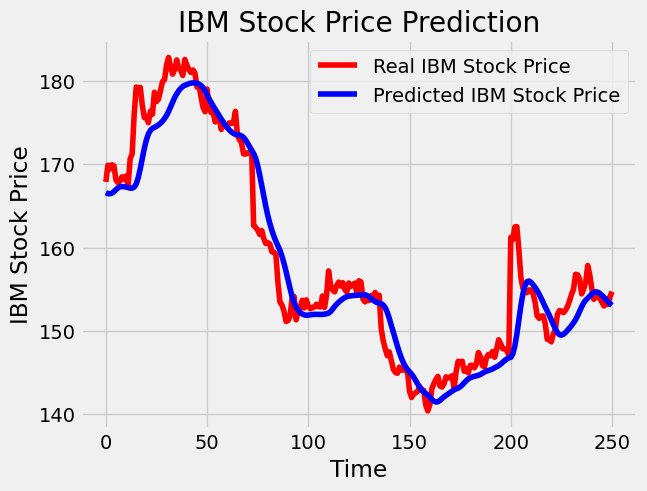

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.444608257253095.
